Laidin Tino, end-of-studies internship

# Kinetic/Fluid coupling in diffusion limit

## Vlasov
We are interested in the following transport equation 
$$\partial_t f^\varepsilon + \frac{1}{\varepsilon}v\partial_x f^\varepsilon = \frac{1}{\varepsilon^2}\left(\rho^\epsilon\mathcal{M}(v) - f^\varepsilon\right)\,,\qquad \rho^\varepsilon(t,x)\ =\ \int f^\varepsilon(t,x,v)\,\mathrm{d}v$$

where $\mathcal{M}$ is a gaussian Maxwellian distribution.

### Chapmann-Enskog
We decompose $f$ as
$$f=\rho\mathcal{M} + \varepsilon g^{(1)}+ \varepsilon^2 g^{(2)}+ \varepsilon^3 g^{(3)} + \dots $$

### Micro-macro model
We stop at order 1 in the Chapmann-Enskog expansion to derive the following micro-macro model with $f=\rho\mathcal{M}+g$

$$ 
\left\lbrace\begin{aligned}
\partial_tg+\frac{1}{\varepsilon}\left(\mathcal{T}g-\partial_x\langle vg\rangle\mathcal{M}\right)+\frac{1}{\varepsilon}\mathcal{T}(\rho\mathcal{M})&=\frac{-1}{\varepsilon^2}g\\
\partial_t\rho+\frac{1}{\varepsilon}\partial_x\langle vg\rangle&=0,
\end{aligned}\right.
$$

with $\mathcal{T}f=v\partial_xf$ the transport operator, $\rho = \langle f\rangle$ and $\langle f\rangle=\int f dv$.
When $\varepsilon\longrightarrow 0$ we have a diffusion limit where $\rho$ satisfies:

$$\partial_t\rho-<v^2\mathcal{M}>\partial_{xx}\rho=0 $$

In [1]:
%matplotlib inline
from MMCentered_solvers import *

In [2]:
name = "BGK"

### Velocity discretization

The velocity domain is a bounded symmetric segment $[-v_{\star},v_{\star}]$. 
We consider a primal mesh of this interval composed of $N_v = 2L$ control volumes arranged symmetrically around $v = 0$. We thus get $2L+1$ distinct interface points denoted by $v_{j+\frac{1}{2}}$. In this way $v_{-L+1/2} = -v_{\star}$, $v_{1/2} = 0$ and $v_{j+1/2} = -v_{-j+1/2}$. Each cell has length $\Delta v_{j}=v_{j+\frac{1}{2}}-v_{j-\frac{1}{2}}$ and midpoint $v_j$.

In [3]:
vstar = 8.0 #Right endpoint
L = 32 #Number of positive velocity cells
(v,vhalf,dv,Nv,vmin,vmax) = discretizeV(L,vstar)

### Space discretization
In space, we consider a discretization of the torus $\mathbb{T}_{x_\star} = \mathbb{R}/x_\star\mathbb{Z}$ into $N_x$ subintervals of length $\Delta x_{i}$ and centers $x_{i}$.

In [4]:
xstar = np.pi #Length of the domain
Nx = 3**3 #Number of cells
(x,xhalf,dx,invdx,Nx,xmin,xmax) = discretizeX(Nx,xstar)

### Phase space discretization

In [5]:
(X,V,DV,DX,invDX,N) = discretizeXV(x,Nx,dx,invdx,v,Nv,dv)

## Discrete Maxwellian

In [6]:
dist = gaussian
    
(M,Mhalf,MM) = Maxwellian(dist, v, vhalf, dv,Nx)
m0 = Maxw_moment(M,0,v,dv)
m2 = Maxw_moment(M,2,v,dv)
m4 = Maxw_moment(M,4,v,dv)
print("0th moment :", m0)
print("2nd moment :", m2)
print("4th moment :", m4)

0th moment : 0.9999999999999999
2nd moment : 0.9999999999999307
4th moment : 2.9999999999953193


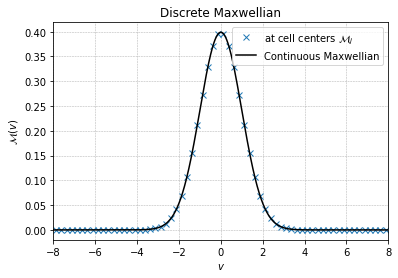

In [7]:
plt.rcParams['figure.figsize'] = 6, 4
plt.figure
plt.xlabel(r'$v$')
plt.ylabel(r'$\mathcal{M}(v)$')
plt.xlim([vmin, vmax])

vplot = np.linspace(vmin,vmax,1000)

Mplot = dist(vplot)
Mass = np.sum(Mplot)*(vplot[2]-vplot[1])
Mplot = Mplot/Mass
plt.plot(v, M, label = 'at cell centers $\mathcal{M}_{j}$', marker = 'x', ls = 'None')
plt.plot(vplot, Mplot, label = "Continuous Maxwellian", color = 'black')
plt.title("Discrete Maxwellian")
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Initial data and equilibrium

### Initial data

In [8]:
def init_custom(X,V,xstar):
    """ Brief: debug initial condition 
    Input:
        - X,V: phase space discretisation (meshgrid form)
    Output:
        - F: Initial data (meshgrid form)
    """
    
    F = gaussian(V-4.0)*gaussian((X-np.pi/2)/0.3) + gaussian(V)*gaussian((X-np.pi/2)/0.3) 
    F += gaussian(V+4.0)*gaussian((X-np.pi/2)/0.3) + 0.1*gaussian(V)*V**4*(1+1*np.cos(2 * np.pi * X / xstar))

    return F

In [9]:
init_data = 0

if init_data == 1:
    F = init_Gaussian(X,V,xstar)
    test = "Gaussian"
elif init_data == 2:
    F = init_Oscillation(X,V,xstar)
    test = "Oscillation"
elif init_data == 3:
    F = init_other(X,V,xstar)
    test = "Other"
else:
    F = init_custom(X,V,xstar)
    test = "Custom"

### Equilibrium
The equilibrium is a Maxwellian with the same mass as the initial data.
$$
f^\infty_{ij}\ =\ m_f\,\mathcal{M}_j
$$
with 
$$
m_f = \frac{1}{x_\star}\sum_{i,j}f^0_{ij}\,\Delta x_i\,\Delta v_j
$$
so that 
$$
\sum_{i,j}(f^0_{ij}-f^\infty_{ij})\,\Delta x_i\,\Delta v_j\ =\ 0
$$

In [10]:
(Finf,mf) = Equilibrium(F,MM,DX,DV,xstar)

### Numerical scheme
$g$ and $\rho$ is discretised at cell centers. $g(t^n,x_{i,j},v_j)\approx g^n_{i,j}$ for $i=0,\dots,Nx-1$ and $\rho(t^n,x_i)\approx \rho^n_i$ for $i=1,\dots,Nx$.

$$
\phi^n_{i,j} = v_j^+\frac{g^n_{i,j}-g^n_{i-1,j}}{\Delta x} + v_j^-\frac{g^n_{i+1,j}-g^n_{i,j}}{\Delta x}
$$

$$ 
\left\lbrace\begin{aligned}
g^{n+1}_{i,j}\left(\frac{\varepsilon^2}{\Delta t}+1\right)&=g^n_{i,j}\frac{\varepsilon^2}{\Delta t}-\varepsilon\left(\phi^n_{i,j}-\left\langle\phi^n_{i,j}\right\rangle M_j\right)- \varepsilon v_jM_j\frac{\rho_{i+1}^{n}-\rho_{i-1}^n}{\Delta x} \\
~~\\
\rho_i^{n+1} &= \rho_{i}^{n}-\frac{\Delta t}{\varepsilon\Delta x}\left\langle v_j\left(g^{n+1}_{i+1,j}-g^{n+1}_{i-1,j}\right)\right\rangle
\end{aligned}\right.
$$
Injecting $g^{n+1}$ in $\rho_i^{n+1}$ gives:
$$
\rho_i^{n+1} = \rho_{i}^{n}-\frac{\Delta t}{2\Delta x}\left(\frac{\varepsilon^2}{\Delta t}+1\right)^{-1} \left[\frac{\varepsilon}{\Delta t}\left\langle v_j(g^n_{i+1,j}-g^n_{i-1,j})\right\rangle - \left\langle v_j(\phi_{i+1,j}-\phi_{i-1,j})\right\rangle - m_2\frac{\rho_{i+2}^{n}-2\rho_{i}^{n}+\rho_{i-2}^{n}}{2\Delta x} \right]
$$
We can now explicitly take $\varepsilon = 0$. Moreover, the asymptotic scheme reads
$$
\rho^{n+1}_i=\rho^{n}_i - m_2\frac{\Delta t}{4 \Delta x^2}\left( \rho_{i+2}^{n}-2\rho_{i}^{n}+\rho_{i-2}^{n}\right)
$$

In [11]:
(Rho0,G0) = initAll(F, Finf, MM, DV, mf)

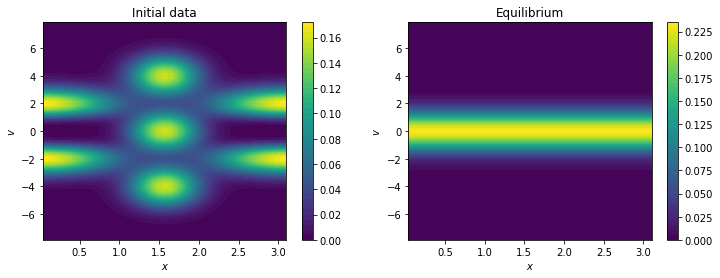

In [12]:
plt.rcParams['figure.figsize'] = 12, 4

plt.subplot(1,2,1)
plt.contourf(X,V,F, 50,cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Initial data')
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')

plt.subplot(1,2,2)
plt.contourf(X,V,Finf, 50,cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Equilibrium')
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')

plt.show()

### Time discretization
The stability conditions implies that 
$$ \Delta t\leq2C\frac{\Delta x^2}{m_2^{\Delta v}} $$ 
for the limit scheme and 
$$ \Delta t\leq 4C^3\left(\frac{\Delta x}{v^\star}\right)^2 $$
for the micro macro one. Therefore, we take $\Delta t$ such that both condition are fulfilled.

### Time loop

In [13]:
# Knudsen number
epsilon = 0.5
# Time step and final time
C = 1.0
(dt,dtLim,dtMM) = CFL(np.max(dx),m2,vstar,epsilon,C)
T = 5.0
# dt=dtLim

print('|---------------------------------------------------------')
print('| Time steps :')
print('| MM    : ', dtMM)
print('| Limit : ', dtLim)
print('| Used  : ', dt)
print('| Final time  : ', T)
print('|------------------')
i = 0
t = [0]

# Initialize unknows
(Rho,G) = (Rho0,G0)
Fn = F
fluid = Rho[0,:]

# A single kinetic region with ghost cells
reg = [i for i in range(-2,Nx)]
reg.extend([0,1])
regions = [reg]

F_    = [Fn.copy()]
Rho_  = [Rho.copy()] 
fluid_= [fluid.copy()]

# Initialize Control variates
(L2f_, L2G_, L2Rho_, L2fluid_) = diagnostic(Fn, G, Rho, fluid, MM, DV, DX, mf)

L2f     = [L2f_]
L2G     = [L2G_]
L2Rho   = [L2Rho_]
L2fluid = [L2fluid_]

(indKinetic, indFluid) = indicators(Rho[0,:], fluid, invdx, m2, m4)
indKinetic_, indFluid_ = [indKinetic], [indFluid]
L1G_ = [np.sum(np.abs(G*DV),axis=0)]

start = time.time()
while t[-1] < T: # and i<1:
    # Update Micro-Macro unknowns and f
    (Rho,G,Fn) = solve_MicroMacro(Rho, G, regions[0], MM, invDX, V, DV, dt, m2, epsilon)

    # Update the diffusion limit (heat equation)
    fluid = solve_Fluid(fluid, regions[0], m2, invdx, dt)
    
    # Save unknowns
    t.append(t[-1] + dt)
    F_.append(Fn.copy())
    Rho_.append(Rho.copy())
    fluid_.append(fluid.copy()) 
    
    # Evaluate and save control variates
    (L2f_, L2G_, L2Rho_, L2fluid_) = diagnostic(Fn, G, Rho, fluid, MM, DV, DX, mf)
    L2f.append(L2f_)
    L2G.append(L2G_)
    L2Rho.append(L2Rho_)
    L2fluid.append(L2fluid_)
    
    (indKinetic, indFluid) = indicators(Rho[0,:], fluid, invdx, m2, m4)
    indKinetic_.append(indKinetic)
    indFluid_.append(indFluid)
    L1G_.append(np.sum(np.abs(G*DV),axis=0))
    
    # Increment
    i = i + 1
stop = time.time()

m, s = divmod(stop-start, 60)
h, m = divmod(m, 60)
print("| Elapsed time: "+'{:f}:{:02f}:{:02f}'.format(h, m, s))
print('|---------------------------------------------------------')

# Transform into numpy arrays
L2f = np.array(L2f)
L2G = np.array(L2G)
L2Rho = np.array(L2Rho)
L2fluid = np.array(L2fluid)

|---------------------------------------------------------
| Time steps :
| MM    :  0.00036695435756578683
| Limit :  0.011742539442105992
| Used  :  0.00036695435756578683
| Final time  :  5.0
|------------------
| Elapsed time: 0.000000:0.000000:9.333211
|---------------------------------------------------------


### Snapshots of the distribution

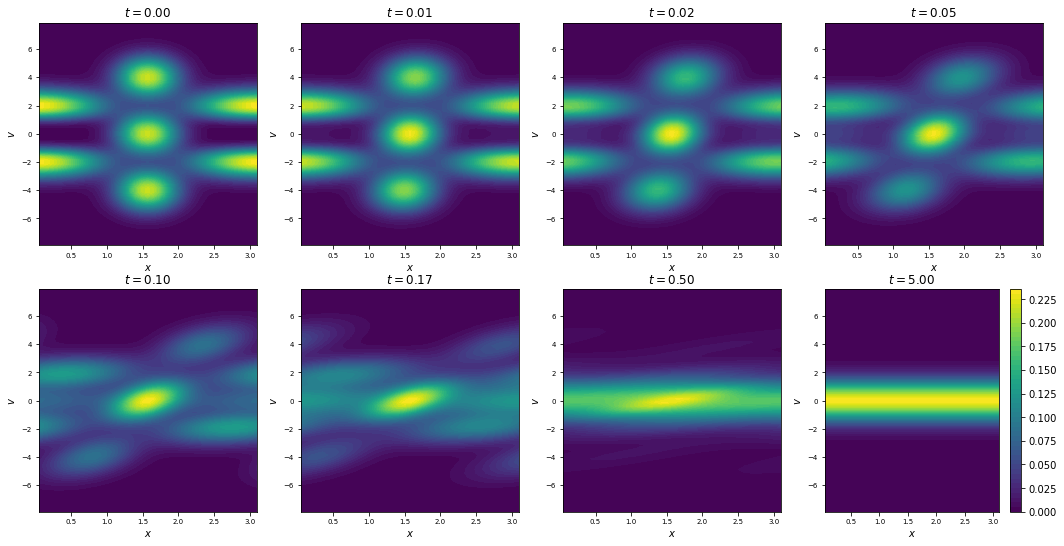

In [14]:
Nt = len(t)
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
plt.rcParams['figure.figsize'] = 18, 9
for i in range(2):
    for j in range(4):
        index = i + j*2
        plt.subplot(2,4,1+i + j*2)
        plt.contourf(X,V,F_[time_indices[index]], 50, cmap=plt.cm.viridis)
        plt.title(r'$t = $'+('%.2f' % t[time_indices[index]]))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$v$')
        plt.tick_params(axis='both', which='major', labelsize=7)
plt.colorbar()
plt.show()

### Snapshots of the densities

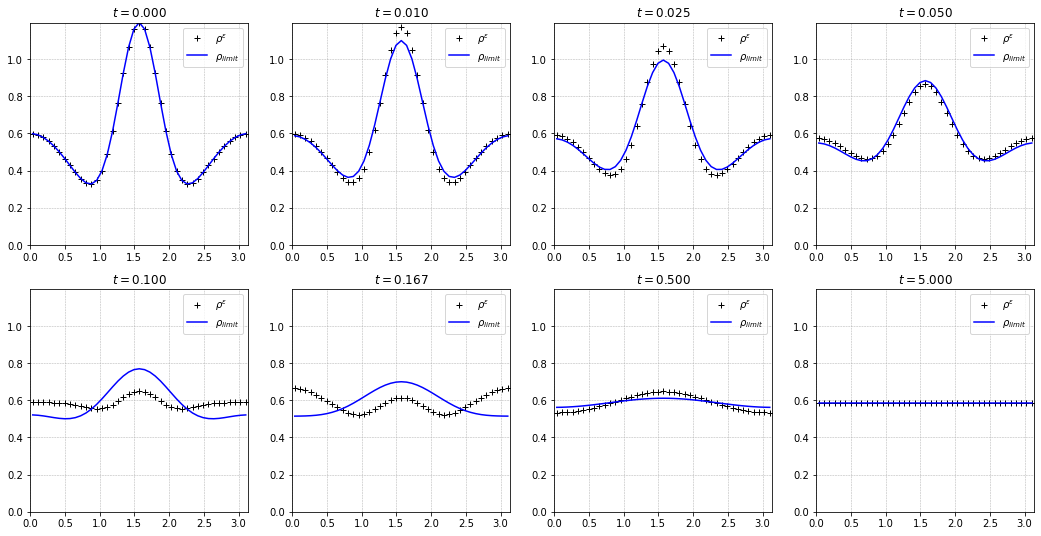

In [15]:
plt.rcParams['figure.figsize'] = 18, 9
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
rho_max = np.max(Rho_[0])
for i in range(2):
    for j in range(4):
        index = i + j*2
        ax = plt.subplot(2,4,1+i + j*2)
        plt.plot(x,Rho_[time_indices[index]][0,:], 'k+', label=r'$\rho^\varepsilon$')
        plt.plot(x,fluid_[time_indices[index]], 'b-', label=r'$\rho_{limit}$')
        plt.title(r'$t = '+('%.3f' % t[time_indices[index]])+'$')
        plt.ylim(0, rho_max)
        plt.xlim(0, xstar)
        plt.grid(linestyle='--', linewidth=0.5)
        plt.legend()
plt.show()

### Coupling indicators

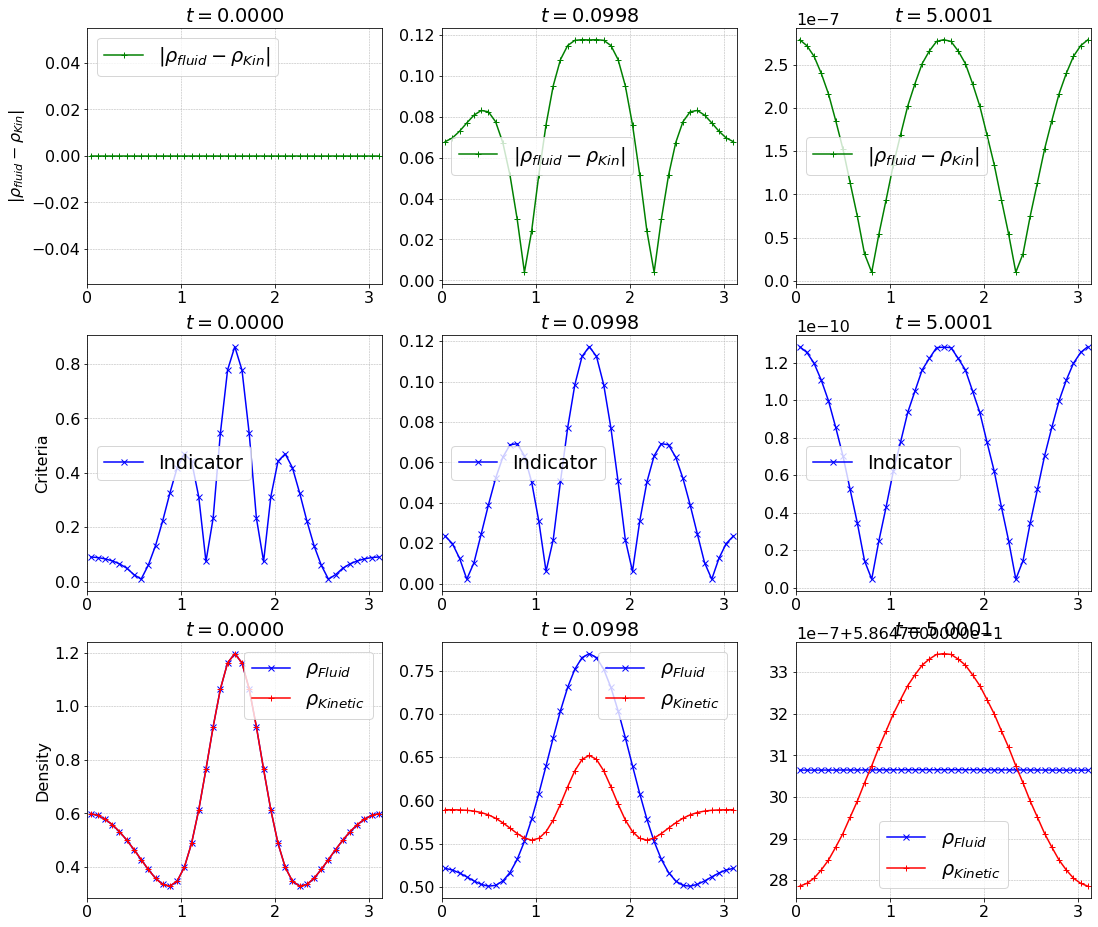

In [16]:
plt.rcParams['figure.figsize'] = 18, 16
plt.rcParams.update({'font.size': 16})
eta = 5
time_indices = [0, len(t)//50, len(t)-1]
lines = 3
cols  = 3
index = 0

i = 0
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel(r'$|\rho_{fluid}-\rho_{Kin}|$')
    diff=np.abs(fluid_[time_indices[index]]-Rho_[time_indices[index]][0,:])
    plt.plot(x,diff, 'g-+', label=r'$|\rho_{fluid}-\rho_{Kin}|$')
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    if j==0:
        plt.legend(fontsize='large', loc=2)
    else:
        plt.legend(fontsize='large', loc=6)
    index +=1
    
i = 1
index = 0
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel('Criteria')
    criteria = np.abs(indFluid_[time_indices[index]])
    plt.plot(x,criteria, 'b-x', label='Indicator')
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large', loc=6)
    index +=1

i = 2
index = 0
rho_max = np.max(Rho_)
rho_min = np.min(Rho_)
for j in range(cols):
    ax = plt.subplot(lines,cols,(i*cols) + (j+1))
    if j == 0 : plt.ylabel('Density')
    plt.plot(x,fluid_[time_indices[index]], 'bx-', label=r'$\rho_{Fluid}$')
    plt.plot(x,Rho_[time_indices[index]][0,:], 'r+-', label=r'$\rho_{Kinetic}$')
    plt.title(r'$t = '+('%.4f' % t[time_indices[index]])+'$')
#     plt.ylim(rho_min, rho_max)
    plt.xlim(0, xstar)
    plt.grid(linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large')
    index +=1
plt.show()
plt.rcParams.update({'font.size': 10})

### Convergence to equilibrium

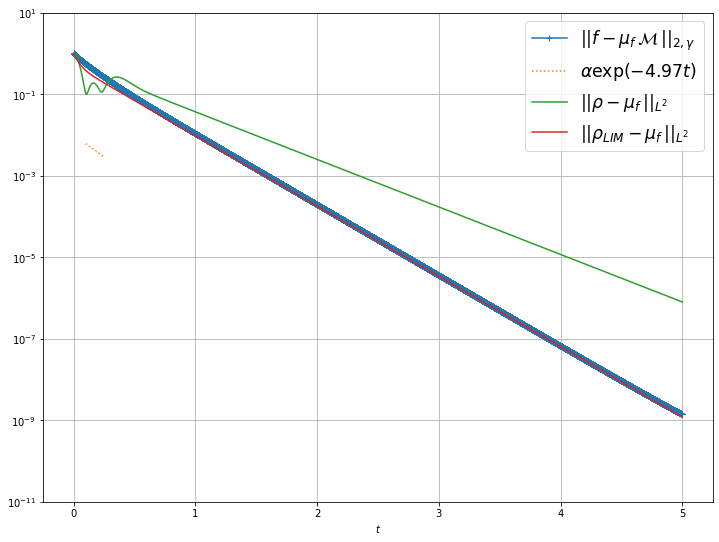

In [17]:
plt.rcParams['figure.figsize'] = 12, 9
N1, N2 = len(t)//50, len(t)//20
rate = (np.log(L2f[N2]) - np.log(L2f[N1]))/(t[N2] - t[N1])
ax=plt.subplot(1,1,1)
plt.xlabel('$t$')
plt.semilogy(t[1:],L2f[1:]/L2f[0],'+-', label = r'$||f-\mu_f\,\mathcal{M}\,||_{2,\gamma}$')
plt.semilogy(t[N1:N2],1e-2*np.exp(rate*np.array(t[N1:N2])), ':', label=r'$\alpha \exp({:0.2f}t)$'.format(rate))
plt.semilogy(t,L2Rho/L2Rho[0],'-', label = r'$||\rho-\mu_f\,||_{L^2}$')
plt.semilogy(t,L2fluid/L2fluid[0], label = r'$||\rho_{LIM}-\mu_f\,||_{L^2}$')
plt.ylim([1e-11,10])
# plt.xlim(0,10)
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()

## Dynamic coupling

### Higher order model
To derive a coupling criterion on wether to consider the kinetic or the fluid model, we are interested an higher order model. We now consider the Chapmann-Enskog expansion up to 3rd order. Indeed, order 2 gives no further information. As $\varepsilon\longrightarrow 0$ the higher order fluid limit is given by

$$\partial_t\rho-\partial_{xx}\left(m_2\rho-\varepsilon^2(2m_2^2+m_4)\partial_{xx}\rho \right)=0,$$

where $m_i=<v^i\mathcal{M}>$. As $\mathcal{M}$ is an even function, odd moments of $\mathcal{M}$ are necessarily 0. This justifies the choice of the 3rd order in the Chapmann-Enskog expansion.
The difference with the diffusive limit presented before leads us to use the quantity $|(2m_2+m_4)\partial_{xx}\rho|$ as our coupling criterion.

In [18]:
# Knudsen number
epsilon = 0.1

# Time step and final time
C = 0.8
(dt,dtLim,dtMM) = CFL(np.max(dx),m2,vstar,epsilon,C)
T = 5.0

# Enables dynamic coupling
Coupling = True
# Coupling = False

# Coupling criterion
eta   = 1e-4 # A bigger value makes it easier for cells to become fluid
delta = 1e-4 # Same here
print('|---------------------------------------------------------')
print('| Time steps :')
print('| MM    : ', dtMM)
print('| Limit : ', dtLim)
print('| Used  : ', dt)
print('| Final time  : ', T)
print('|------------------')
print('| Coupling :', Coupling)
if Coupling :
    print('| delta0 : ', delta)
    print('| eta0   : ', eta)
print('|------------------')

order = 1
i = 0
t = [0]

# Initialize unknows
(Rho,G) = (Rho0,G0)
(RhoMM,GMM) = (Rho0,G0)
Fn   = F
FnMM = F
fluid = Rho[0,:]

# Initialize Control variates
(L2f_, L2G_, L2Rho_, L2fluid_) = diagnostic(Fn, G, Rho, fluid, MM, DV, DX, mf)

L2f     = [L2f_]
L2G     = [L2G_]
L2Rho   = [L2Rho_]
L2fluid = [L2fluid_]

massC   = [np.sum(Rho[0,:]*dx)]
mass    = [np.sum(RhoMM[0,:]*dx)]

#Initialize the system with full information i.e. the kinetic model
isKinetic = np.full(Nx, True, dtype=bool) # True = kinetic, False = fluid
AllFluid  = np.full(Nx, False, dtype=bool)
# A single kinetic region with ghost cells
reg = [i for i in range(-2,Nx)]
reg.extend([0,1])
regions = [reg]

F_ = [Fn.copy()]
Rho_ = [Rho[0,:].copy()]
RhoMM_ = [RhoMM[0,:].copy()]
fluid_= [fluid.copy()]
isKinetic_ = [isKinetic.copy()]

start= time.time()
while t[-1] < T:
    # Update Micro-Macro unknowns and f
    (Rho,G,Fn,isKinetic,regions) = solve_Coupled(Rho, G, isKinetic, regions, eta, delta,
                                                 MM, invDX, V, DV, dt, m2, m4, epsilon,Coupling,order)
    
    (RhoMM,GMM,FnMM) = solve_MicroMacro(RhoMM, GMM, regions[0], MM, invDX, V, DV, dt, m2, epsilon)
    
    fluid = solve_Fluid(fluid, regions[0], m2, invdx, dt)

#     if (isKinetic==AllFluid).all():
#         dt = dtLim
#         FullFluid = True
#     else:
#         dt = dtMM
    
    # Save unknowns
    t.append(t[-1] + dt)
    isKinetic_.append(isKinetic.copy())
    F_.append(Fn.copy())
    Rho_.append(Rho[0,:].copy())
    RhoMM_.append(RhoMM[0,:].copy())
    fluid_.append(fluid.copy()) 
    
#     Evaluate and save control variates
    (L2f_, L2G_, L2Rho_, L2fluid_) = diagnostic(Fn, G, Rho, fluid, MM, DV, DX, mf)
    L2f.append(L2f_)
    L2G.append(L2G_)
    L2Rho.append(L2Rho_)
    L2fluid.append(L2fluid_)
    
    massC.append(np.sum(Rho[0,:]*dx))
    mass.append(np.sum(RhoMM[0,:]*dx))
    
    # Increment
    i = i + 1
stop = time.time()
m, s = divmod(stop-start, 60)
h, m = divmod(m, 60)
print("| Elapsed time: "+'{:f}:{:02f}:{:02f}'.format(h, m, s))
print('|---------------------------------------------------------')

# Transform into numpy arrays
L2f = np.array(L2f)
L2Rho = np.array(L2Rho)
massC = np.array(massC)
mass  = np.array(mass)

|---------------------------------------------------------
| Time steps :
| MM    :  0.0001878806310736829
| Limit :  0.009394031553684795
| Used  :  0.0001878806310736829
| Final time  :  5.0
|------------------
| Coupling : True
| delta0 :  0.0001
| eta0   :  0.0001
|------------------
| Elapsed time: 0.000000:0.000000:50.572039
|---------------------------------------------------------


### Snapshots of the distribution function

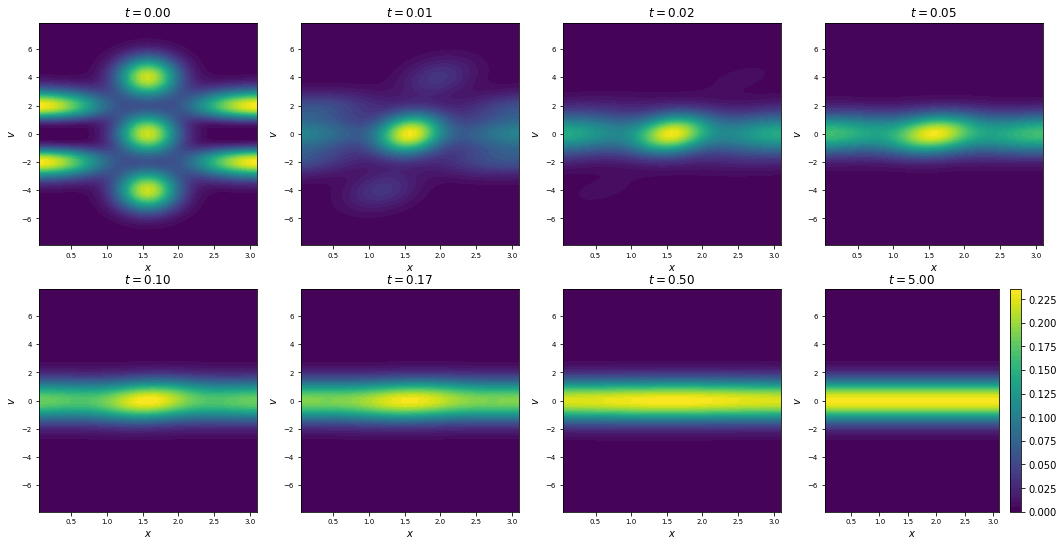

In [19]:
Nt = len(t)
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
plt.rcParams['figure.figsize'] = 18, 9
for i in range(2):
    for j in range(4):
        index = i + j*2
        plt.subplot(2,4,1+i + j*2)
        plt.contourf(X,V,F_[time_indices[index]], 50, cmap=plt.cm.viridis)
        plt.title(r'$t = $'+('%.2f' % t[time_indices[index]]))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$v$')
        plt.tick_params(axis='both', which='major', labelsize=7)
plt.colorbar()
plt.show()

### Snapshots of the densities

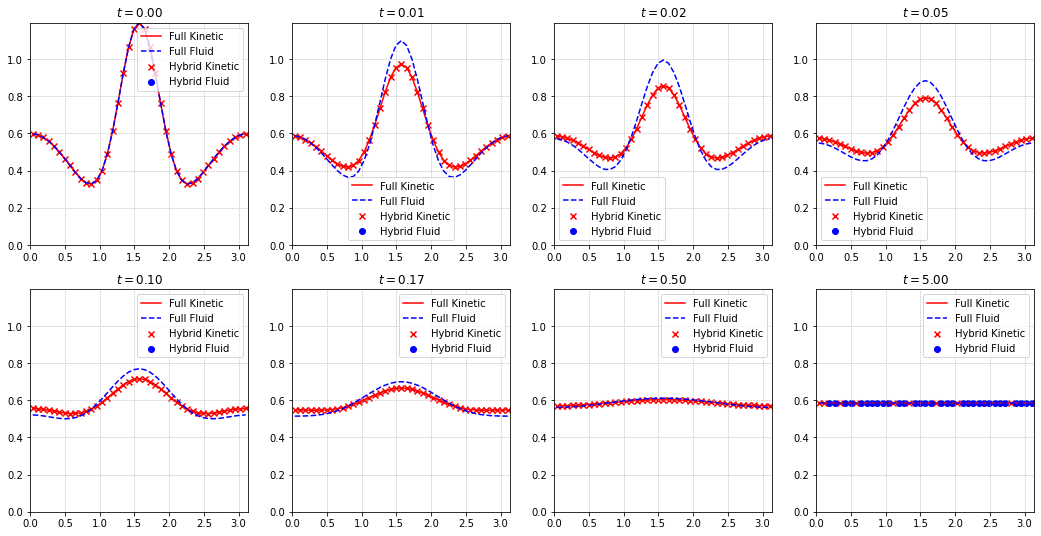

In [20]:
plt.rcParams['figure.figsize'] = 18, 9
time_indices = [0, len(t)//500, len(t)//200, len(t)//100, len(t)//50, len(t)//30, len(t)//10, len(t)-1]
rho_max = np.max(Rho_[0])
for i in range(2):
    for j in range(4):
        index = i + j*2
        date = time_indices[index]
        ax = plt.subplot(2,4,1+i + j*2)
        plt.plot(x,RhoMM_[date], 'r-', label=r'Full Kinetic')
        plt.plot(x,fluid_[date], 'b--', label=r'Full Fluid')
        plt.scatter(x[isKinetic_[date]],  Rho_[date][isKinetic_[date]],  marker='x', c='r', zorder=-1, label=r'Hybrid Kinetic')
        plt.scatter(x[~isKinetic_[date]], Rho_[date][~isKinetic_[date]], marker='o', c='b', label=r'Hybrid Fluid')
        
        plt.title(r'$t = '+('%.2f' % t[date])+'$')
        plt.ylim(0, rho_max)
        plt.xlim(0, xstar)
        plt.grid(linestyle='--', linewidth=0.5)
        plt.legend()
plt.show()

### State of the cells and mass variation

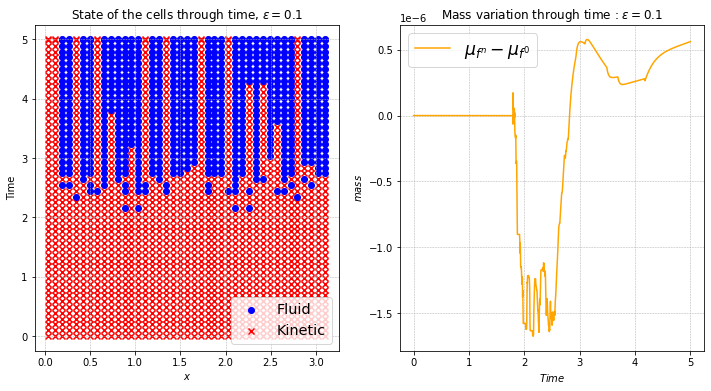

In [21]:
step = len(t)//51
date = t[0]
plt.rcParams['figure.figsize'] = 12, 6
plt.subplot(1,2,1)
plt.scatter(x[~isKinetic_[0]], np.ones(Nx)[~isKinetic_[0]]*date, marker='o', c='b', label='Fluid' if date==0 else '')
plt.scatter(x[isKinetic_[0]],  np.ones(Nx)[isKinetic_[0]]*date,  marker='x', c='r', label='Kinetic'if date==0 else '')
i = 1
for date in t[step::step]:
    plt.scatter(x[~isKinetic_[i]], np.ones(Nx)[~isKinetic_[i]]*date, marker='o', c='b')
    plt.scatter(x[isKinetic_[i]],  np.ones(Nx)[isKinetic_[i]]*date,  marker='x', c='r', zorder=-1)
    i = i+ step
plt.scatter(x[~isKinetic_[-1]], np.ones(Nx)[~isKinetic_[-1]]*t[-1], marker='o', c='b')
plt.scatter(x[isKinetic_[-1]],  np.ones(Nx)[isKinetic_[-1]]*t[-1],  marker='x', c='r', zorder=-1)
plt.title('State of the cells through time, '+r'$\varepsilon=$'+str(epsilon))
plt.xlabel(r'$x$')
plt.ylabel('Time')
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize='x-large', loc='lower right')

plt.subplot(1,2,2)
plt.plot(t,massC-mass[0],c='orange',label=r'$\mu_{f^n} - \mu_{f^0}$')
plt.grid(linestyle='--', linewidth=0.5)
plt.title('Mass variation through time : '+r'$\varepsilon=$'+str(epsilon))
plt.legend(fontsize='xx-large')
plt.xlabel(r'$Time$')
plt.ylabel(r'$mass$')
plt.show()

### Convergence to equilibrium

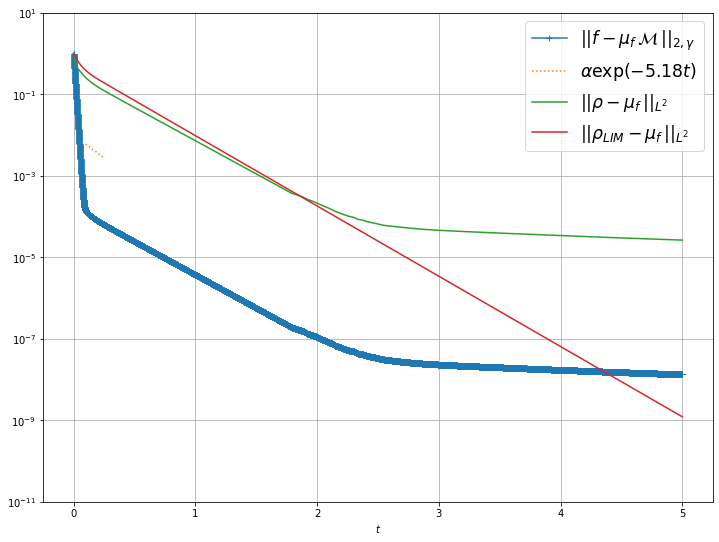

In [22]:
plt.rcParams['figure.figsize'] = 12, 9
N1, N2 = len(t)//50, len(t)//20
rate = (np.log(L2f[N2]) - np.log(L2f[N1]))/(t[N2] - t[N1])
ax=plt.subplot(1,1,1)
plt.xlabel('$t$')
plt.semilogy(t[1:],L2f[1:]/L2f[0],'+-', label = r'$||f-\mu_f\,\mathcal{M}\,||_{2,\gamma}$')
plt.semilogy(t[N1:N2],1e-2*np.exp(rate*np.array(t[N1:N2])), ':', label=r'$\alpha \exp({:0.2f}t)$'.format(rate))
plt.semilogy(t,L2Rho/L2Rho[0],'-', label = r'$||\rho-\mu_f\,||_{L^2}$')
plt.semilogy(t,L2fluid/L2fluid[0], label = r'$||\rho_{LIM}-\mu_f\,||_{L^2}$')
plt.ylim([1e-11,10])
# plt.xlim(0,10)
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()